In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, get_file
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout


# small library for seeing the progress of loops.
from tqdm.notebook import tqdm # Changed import here
tqdm().pandas()

0it [00:00, ?it/s]

In [2]:
def load_doc(filename):
    file = open(filename, 'r')         # opens the file in read-only mode
    text = file.read()                 # read the whole file into a string
    file.close()                       # close the file to free up memory
    return text                        # return the text as a string

def all_img_captions(filename):
    file = load_doc(filename)         # get text from the caption file
    captions = file.split('\n')       # split it into lines (each line = one caption)
    descriptions = {}                 # create an empty dictionary

    for caption in captions[:-1]:     # looping through each line (except last if empty)
        img, caption = caption.split('\t')

        if img[:-2] not in descriptions:       # remove the "#0" part
            descriptions[img[:-2]] = [caption] # add the caption as a list
        else:
            descriptions[img[:-2]].append(caption)  # add the caption to the list for that image

    return descriptions


In [3]:
def cleaning_text(captions):
    table = str.maketrans('', '', string.punctuation)

    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):

            img_caption.replace("-", " ")             # replaces hyphens with space
            desc = img_caption.split()                # split into words

            desc = [word.lower() for word in desc]    # lowercase everything
            desc = [word.translate(table) for word in desc]  # remove punctuation
            desc = [word for word in desc if len(word) > 1]  # remove short junk like 'a'
            desc = [word for word in desc if word.isalpha()] # remove numbers and non-letters

            img_caption = ' '.join(desc)              # re-join cleaned words
            captions[img][i] = img_caption            # update the list

    return captions

def text_vocabulary(descriptions):
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#Finally saving up descriptions in a particular file
def save_descriptions(descriptions, filename):
    lines = list()

    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)

    data = "\n".join(lines)
    file = open(filename, "w")
    file.write(data)
    file.close()


In [4]:
dataset_text = "/content/drive/MyDrive/ML_Project_visual/Flickr8k_text"
dataset_images = "/content/drive/MyDrive/ML_Project_visual/Flickr8k_Dataset/Flicker8k_Dataset"

#I prepare my text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
# #loading the file that contains all data
# #mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

# #cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

# #building vocabulary
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [5]:
# def download_with_retry(url, filename, max_retries=3):
#     for attempt in range(max_retries):
#         try:
#             return get_file(filename, url)
#         except Exception as e:
#             if attempt == max_retries - 1:
#                 raise e
#             print(f"Download attempt {attempt + 1} failed. Retrying in 5 seconds...")
#             time.sleep(5)

# # Replace the Xception model initialization with:
# weights_url = "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
# weights_path = download_with_retry(weights_url, 'xception_weights.h5')
# model = Xception(include_top=False, pooling='avg', weights=weights_path)

# def extract_features(directory):
#     features = {}
#     valid_images = ['.jpg', '.jpeg', '.png']  # Add other formats if needed

#     for img in tqdm(os.listdir(directory)):
#         # Skip files that don't end with valid image extensions
#         ext = os.path.splitext(img)[1].lower()
#         if ext not in valid_images:
#             continue

#         filename = directory + "/" + img
#         image = Image.open(filename)
#         image = image.resize((299,299))
#         image = np.expand_dims(image, axis=0)
#         image = image/127.5
#         image = image - 1.0

#         feature = model.predict(image)
#         features[img] = feature
#     return features

# # 2048 feature vector
# features = extract_features(dataset_images)
# dump(features, open("features.p","wb"))


In [6]:
features = load(open("/content/drive/MyDrive/ML_Project_visual/features.p","rb"))

#load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    photos_present = [photo for photo in photos if os.path.exists(os.path.join(dataset_images, photo))]
    return photos_present


def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


In [7]:

def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/ML_Project_visual/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


In [8]:
#creating tokenizer class

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))


In [9]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(train_descriptions)
print(max_length)


7577
34


In [10]:
def data_generator(descriptions, features, tokenizer, max_length):
    def generator():
        while True:
            for key, description_list in descriptions.items():
                feature = features[key][0]
                input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
                for i in range(len(input_image)):
                    yield {'input_1': input_image[i], 'input_2': input_sequence[i]}, output_word[i]

    # Define the output signature for the generator
    output_signature = (
        {
            'input_1': tf.TensorSpec(shape=(2048,), dtype=tf.float32),
            'input_2': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
    )

    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    return dataset.batch(32)

In [11]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

# model = define_model(vocab_size, max_length)
# epochs = 10

# def get_steps_per_epoch(train_descriptions):
#     total_sequences = 0
#     for img_captions in train_descriptions.values():
#         for caption in img_captions:
#             words = caption.split()
#             total_sequences += len(words) - 1
#     # Ensure at least 1 step, even if sequences < batch_size
#     return max(1, total_sequences // 32)

# # Update training loop
# steps = get_steps_per_epoch(train_descriptions)

# # making a directory models to save our models
# os.mkdir("models2")
# for i in range(epochs):
#     dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
#     model.fit(dataset, epochs=4, steps_per_epoch=steps, verbose=1)
#     model.save("models2/model_" + str(i) + ".h5")



Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  34


In [12]:

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length,padding="post")[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
dataset = data_generator(train_descriptions, features, tokenizer, max_length)
for (a, b) in dataset.take(1):
    print(a['input_1'].shape, a['input_2'].shape, b.shape)
    break

(32, 2048) (32, 34) (32, 7577)


In [13]:
import os

model_save_dir = "/content/drive/MyDrive/ML_Project_visual/models2"  # Replace with your desired path
os.makedirs(model_save_dir, exist_ok=True)

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from keras.utils import plot_model


In [15]:
img_path = "/content/drive/MyDrive/ML_Project_visual/Flickr8k_Dataset/Flicker8k_Dataset/102351840_323e3de834.jpg"

In [16]:
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        return None

    image = image.resize((299,299))
    image = np.array(image)

    if image.shape[2] == 4:
        image = image[..., :3]

    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0

    feature = model.predict(image)
    return feature


In [17]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [18]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


In [19]:
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, use_cudnn=False)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [20]:
max_length = 32
tokenizer = load(open("tokenizer.p", "rb"))
vocab_size = len(tokenizer.word_index) + 1

model = define_model(vocab_size, max_length)
model.load_weights('/content/drive/MyDrive/ML_Project_visual/models2/model_9.h5')  # ✅ Replace path if saved elsewhere

xception_model = Xception(include_top=False, pooling="avg")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 256)   │  1,939,712 │ input_2[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 32)        │          0 │ input_2[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7577)      │  1,947,289 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Generated Caption:

start man is standing on the rocks with his arms spread end


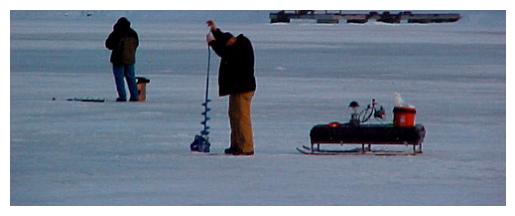

In [21]:
photo = extract_features(img_path, xception_model)
img = Image.open('/content/drive/MyDrive/ML_Project_visual/Flickr8k_Dataset/Flicker8k_Dataset/102351840_323e3de834.jpg')
description = generate_desc(model, tokenizer, photo, max_length)

print("\nGenerated Caption:\n")
print(description)

plt.imshow(img)

plt.axis('off')
plt.show()
